## Ensembling

Nesse exercício vamos observar problemas de overfitting e underfitting e tentar criar ensembles simples parar mitigar tais problemas. Iremos juntos:

* Plotar os dados e observar a correlação entre x e y
* Utilizar `DecisionTreeRegressor` para treinar e visualizar um regressor nesses dados
* Experimentar com alguns parâmetros diferentes e observar os efeitos nos modelos
* Iterar N vezes para treinar N modelos diferentes com diferentes amostras dos dados
* Combinar os resultados de todos os modelos e observar o resultado

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [29]:
def eval_auc(clf, x, y):
    ypred = clf.predict_proba(x)[:,1]
    return roc_auc_score(y, ypred)

# Dataset de deafult
df = pd.read_csv('./data/default.csv')
x = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [30]:
def sample(x, y, n):
    idx = np.random.randint(len(x), size=n)
    return x[idx], y[idx]

In [31]:
import utils # O arquivo deve estar na mesmo diretório que o notebook

## Bagging

Nesse exercício vamos experimentar usar a `BaggingClassifier` do sklearn para criar ensembles com regressão logística e árvores de decisão.

In [32]:
from sklearn.ensemble import BaggingClassifier

In [33]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [34]:
BaggingClassifier()

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [35]:
n_estimators = [1,2,3,4,5,10,15,20]
dt_bag_scores = []   
lr_bag_scores = []
for ne in n_estimators:
    dt = DecisionTreeClassifier(max_depth=15, random_state=1)
    lr = LogisticRegression(random_state=1)
    
    dt_bag = BaggingClassifier(dt, n_estimators=ne)
    lr_bag = BaggingClassifier(lr, n_estimators=ne)

    dt_bag.fit(xtrain, ytrain)
    lr_bag.fit(xtrain, ytrain)

    dt_bag_scores.append(eval_auc(dt_bag, xtest, ytest))
    lr_bag_scores.append(eval_auc(lr_bag, xtest, ytest))

    print(ne, dt_bag_scores[-1], lr_bag_scores[-1])


1 0.6479981115957243 0.7032725949192957
2 0.7539808470673747 0.7018908490168341
3 0.7963625939515329 0.7011879700743404
4 0.8210474147114648 0.7050044027509799
5 0.8334597848298358 0.7032612183222336
10 0.8468484561902369 0.7034630994809548
15 0.8479756616191838 0.7056809342230334
20 0.8511918343172256 0.7037089273970117


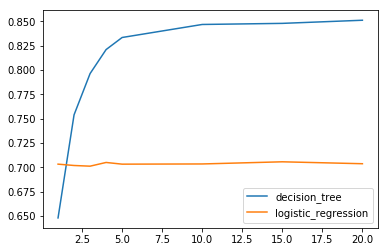

In [36]:
plt.plot(n_estimators, dt_bag_scores, label='decision_tree')
plt.plot(n_estimators, lr_bag_scores, label='logistic_regression')
plt.legend()

Vemos que o desempenho melhora consideravelmente ao combinar múltiplas árvores de decisão, ao contrário de regressões logísticas. Isso acontece por que todos os modelos de regressão logística combinados provavvelmente são muito parecidos, logo combiná-los não trás benefícios. Enquanto as árvores são consideravelmente diferentes, devido ao "problema" de variância que elas possuem.

Esse resultado talvez deixe claro por que *random forests* são tão populares e *random logistic regressions* não :)

## Voting

Vamos usar o `VotingClassifier` do `sklearn` para compor alguns classificadores diferentes.

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

dt1 = DecisionTreeClassifier(random_state=1)
dt2 = DecisionTreeClassifier(max_depth=12, max_features=5, random_state=42)
lr1 = LogisticRegression()
lr2 = LogisticRegression(C=0.001, penalty='l1')
knn = KNeighborsClassifier()

clfs = [('dt1', dt1),
        ('dt2', dt2),
        ('lr1', lr1),
        ('lr2', lr2),
        ('knn', knn)]

vot = VotingClassifier(clfs, voting='soft')
vot.fit(xtrain, ytrain)

VotingClassifier(estimators=[('dt1', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [ ]:
for name, clf in clfs:
    clf.fit(xtrain, ytrain)
    
    auc = eval_auc(clf, xtest, ytest)
    print(name, auc)
    
print()
print('all', eval_auc(vot, xtest, ytest))

## Stacking

Vamos usar os mesmos estimadores base do exemplo anterior, porém ao invés de definir a predição por voto, vamos **treinar outro classificador com as predições dos classificadores base**. Primeiro começamos com nosso split train/test padrão:

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

Agora precisamos fazer um novo split no conjunto de treino para reservar dados para nosso meta-learner.

In [ ]:
xbase, xmeta, ybase, ymeta = train_test_split(xtrain, ytrain, test_size=0.5, random_state=1)

In [ ]:
xmeta_preds = pd.DataFrame(index=ymeta.index)

# ...

In [ ]:
meta_clf = DecisionTreeClassifier(max_depth=7, random_state=1)
# ...

In [ ]:
xtest_meta = pd.DataFrame(index=ytest.index)

# ...

In [ ]:
eval_auc(meta_clf, xtest_meta, ytest)